# Case 1 - Load Factor Prediction

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)  # suppress scientific notation
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.model_selection import KFold
from sklearn import linear_model 
import scipy . linalg as lng
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
# import original xlsx
df = pd.read_excel('Realized Schedule 20210101-20220228.xlsx')

In [3]:
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,0.682796


In [4]:
################################
#Process 'ScheduleTime' Feature#
################################
df.insert(1,'Year', df['ScheduleTime'].dt.year)  # insert a column for year

# calculate days passed from the first day of the year (xxxx-01-01 00:00:00)
df.insert(2,'DateReference', pd.to_datetime(df['Year'].astype(str) + '-01-01 00:00:00'))
df.insert(3,'DaysPassed', 
         ((df['ScheduleTime'] - df['DateReference'])/pd.Timedelta(1, 'd')).fillna(0).astype(int))
# calculate minutes passed from the beginning of the day (00:00:00)
df.insert(4,'MinutesPassed', (df['ScheduleTime'].dt.hour * 60 + df['ScheduleTime'].dt.minute).astype(int))
# calculate day of week (Monday - 0; Sunday - 6)
df.insert(5,'DayOfWeek', (df['ScheduleTime'].dt.dayofweek).astype(int))
df = df.drop('DateReference', 1)

In [5]:
# force types of each column
df['Year'] = df['Year'].astype(int)
df['DaysPassed'] = df['DaysPassed'].astype(int)
df['MinutesPassed'] = df['MinutesPassed'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['Airline'] = df['Airline'].astype(str)
df['FlightNumber'] = df['FlightNumber'].astype(int)
df['Destination'] = df['Destination'].astype(str)
df['AircraftType'] = df['AircraftType'].astype(str)
df['FlightType'] = df['FlightType'].astype(str)
df['Sector'] = df['Sector'].astype(str)
df['SeatCapacity'] = df['SeatCapacity'].astype(int)
df['LoadFactor'] = df['LoadFactor'].astype(float)

In [6]:
###################
#Holiday Indicator#
###################

################################
#Easter of 2021 - 4th of April##
#Easter of 2022 - 17th of April#
################################

multiplier = 7  # the number of days in Easter holiday
def add_holiday(x):
    if x.Year == 2021:
        day = 93  # Easter day of 2021 from new years day
    else:
        day = 106  # Easter day of 2022 from new years day
    indicator = (x.DaysPassed - day) * 0.1 if abs(x.DaysPassed - day) <= 10 else 0
    if indicator < 0:  # before Easter
        indicator += 1
    elif indicator > 0:  # after Easter
        indicator -= 1
    elif abs(x.DaysPassed - day) <= 10:
        indicator = 1
    indicator *= multiplier

    for i, v in x.items():
        if i == 'holidayIndicator':
            indicator += x.holidayIndicator
            break
    return indicator

holiday_column = df.apply(add_holiday, axis=1, result_type='expand')
df.insert(5,'HolidayIndicator', holiday_column.astype(float))

In [7]:
df

,ScheduleTime,Year,DaysPassed,MinutesPassed,DayOfWeek,HolidayIndicator,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,2021,0,395,4,0.0,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,2021,0,635,4,0.0,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,2021,0,725,4,0.0,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,2021,0,800,4,0.0,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,2021,0,860,4,0.0,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,2022,58,1125,0,0.0,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,2022,58,1165,0,0.0,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,2022,58,1200,0,0.0,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,2022,58,1170,0,0.0,LJ,663,RUT,32N,J,US,186,0.682796


In [9]:
# test HolidayIndicator
# pd.set_option('display.max_rows', 1000) # set the maximum number of rows to display
# df.loc[(df['ScheduleTime'].dt.month == 4) & (df['ScheduleTime'].dt.day <= 10) & (df['ScheduleTime'].dt.day >= 1)]

In [10]:
data = df.iloc[:, 1:].values  # dataframe to numpy after pre-processing, discard initial 'ScheduleTime'

################
#Label encoders#
################

# Year
le_year = LabelEncoder()
data[:, 0] = le_year.fit_transform(data[:, 0])
# data[:, 0] = le_year.inverse_transform(data[:, 0].astype(int))

# Airline
le_airline = LabelEncoder()
data[:, 5] = le_airline.fit_transform(data[:, 5])
# data[:, 5] = le_airline.inverse_transform(data[:, 5].astype(int))

# FlightNumber
le_flight_number = LabelEncoder()
data[:, 6] = le_flight_number.fit_transform(data[:, 6])
# data[:, 6] = le_flight_number.inverse_transform(data[:, 6].astype(int))

# Destination 
le_destination = LabelEncoder()
data[:, 7] = le_destination.fit_transform(data[:, 7])
# data[:, 7] = le_destination.inverse_transform(data[:, 7].astype(int))

# AircraftType
le_aircraft_type = LabelEncoder()
data[:, 8] = le_aircraft_type.fit_transform(data[:, 8])
# data[:, 8] = le_aircraft_type.inverse_transform(data[:, 8].astype(int))

# FlightType
le_flight_type = LabelEncoder()
data[:, 9] = le_flight_type.fit_transform(data[:, 9])
# data[:, 9] = le_flight_type.inverse_transform(data[:, 9].astype(int))

# Sector
le_sector = LabelEncoder()
data[:, 10] = le_sector.fit_transform(data[:, 10])
# data[:, 10] = le_sector.inverse_transform(data[:, 10].astype(int))

data = data.astype(float)

> $\textbf{raw_data}$ is the unstandardized version and should never be changed

In [11]:
raw_data = data
print(raw_data.shape)
print(raw_data)

(39449, 13)
[[   0.            0.          395.         ...   11.
   142.            0.4084507 ]
 [   0.            0.          635.         ...    1.
    74.            0.18918919]
 [   0.            0.          725.         ...   11.
   142.            0.57042254]
 ...
 [   1.           58.         1200.         ...   11.
    98.            0.85714286]
 [   1.           58.         1170.         ...   11.
   186.            0.6827957 ]
 [   1.           58.         1285.         ...    1.
   156.            0.82051282]]


In [12]:
# check holiday indicator
# np.set_printoptions(threshold=np.inf)
# print(raw_data[:, 4])

In [13]:
# calculate the mean and standard deviation of two ratio features
# seat capacity
seat_capacity_mean = np.mean(data[:, -2])
seat_capacity_std = np.std(data[:, -2])
print('The mean of seat capacity is {}'.format(seat_capacity_mean))
print('The standard deviation of seat capacity is {}'.format(seat_capacity_std))
# load factor
load_factor_mean = np.mean(data[:, -1])
load_factor_std = np.std(data[:, -1])
print('The mean of load factor is {}'.format(load_factor_mean))
print('The standard deviation of load factor is {}'.format(load_factor_std))

The mean of seat capacity is 155.64571979010876
The standard deviation of seat capacity is 58.65167669113129
The mean of load factor is 0.5374428655008451
The standard deviation of load factor is 0.27309062478150997


In [14]:
# standardize a single feature
def standardization(feature):
    new_feature = (feature - np.mean(feature)) / np.std(feature)
    return new_feature

# DaysPassed
# data[:, 1] = standardization(data[:, 1])
# MinutesPassed
# data[:, 2] = standardization(data[:, 2])
# SeatCapacity
# data[:, -2] = standardization(data[:, -2])
# LoadFactor
# data[:, -1] = standardization(data[:, -1])

# standardize multiple features (a matrix of features)
def standardize_X(features):
    new_features = np.zeros((np.shape(features)[0], np.shape(features)[1]))
    for i in range(np.shape(new_features)[1]):
        new_features[:, i] = standardization(features[:, i])
    return new_features

In [15]:
y_ols = data[:, -1]  # target - unstandardized
X_ols = standardize_X(data[:, :-1])  # features - standardized

<ipython-input-16-639bfc78304a>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


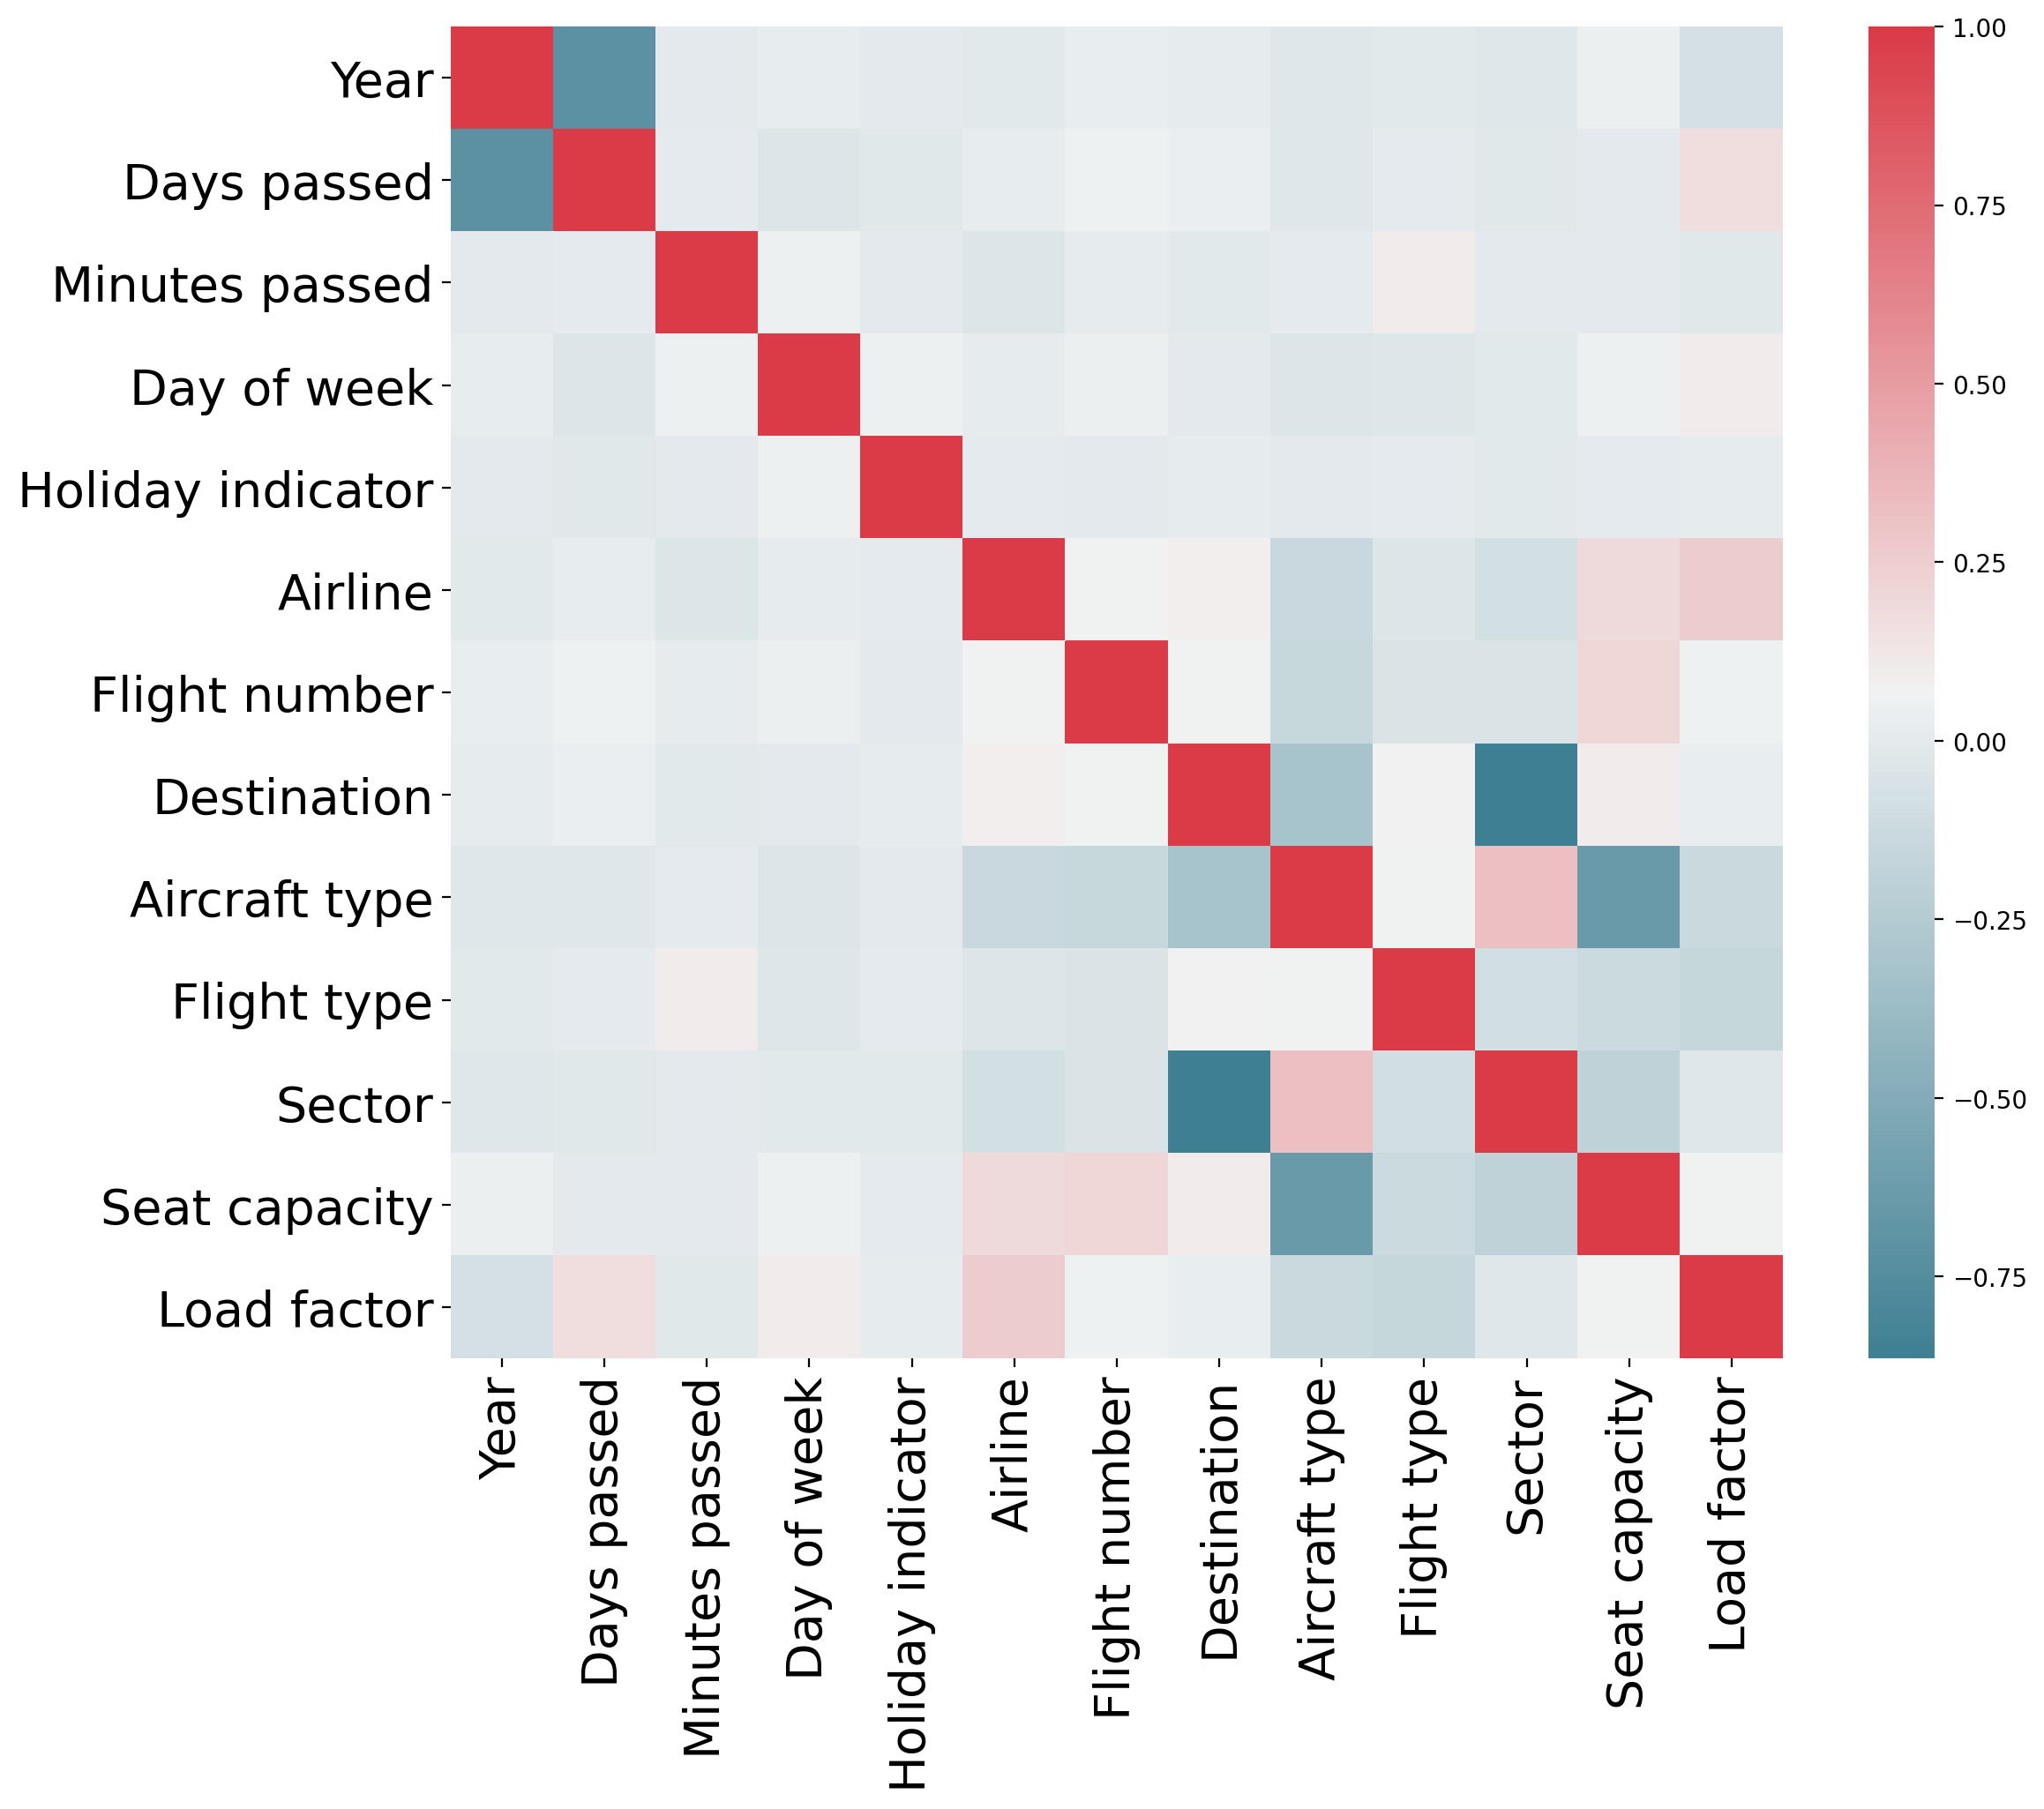

In [16]:
# correlation heatmap of processed data
df2 = pd.DataFrame(standardize_X(data), 
                   columns=['Year', 'Days passed', 'Minutes passed',
                           'Day of week', 'Holiday indicator', 'Airline', 'Flight number', 'Destination', 
                            'Aircraft type', 'Flight type', 'Sector', 'Seat capacity', 'Load factor'])
f, ax = plt.subplots(figsize=(12.5, 10), dpi=200)
corr = df2.corr() # calculates Pearsons coff.
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
# sns.set(font_scale = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("Figures/corr_matrix.png", bbox_inches='tight',dpi=200)

## Ordinary Least Squares (OLS) - baseline
> Here we can also calculate the noise variance $\hat{\delta}_e^2$ of information criterias AIC and BIC

In [17]:
[n, p] = np.shape(X_ols)

beta_ols, _, _, _ = lng.lstsq(X_ols, y_ols)
yhat_ols = np.sum(beta_ols*X_ols, axis=1)
MSE_ols = np.sum((y_ols - yhat_ols)**2)/np.size(y_ols)
print('Weights for OLS regression: \n {}'.format(beta_ols))
print('MSE for OLS regression: {}'.format(MSE_ols))

print('**********************************************************')

# calculate the noise variance of AIC and BIC
e = y_ols - X_ols @ beta_ols
s = np.std(e)  # the noise variance of AIC and BIC
print('The noise variance of AIC and BIC is: {}'.format(s))

Weights for OLS regression: 
 [ 0.02351622  0.06328327 -0.00011309  0.02754652  0.00366633  0.06744619
  0.00511124 -0.00786592 -0.0400616  -0.03966501 -0.00042568 -0.0281002 ]
MSE for OLS regression: 0.35272534565091557
**********************************************************
The noise variance of AIC and BIC is: 0.25274594353452273


Feature: 0, Score: 0.02352
Feature: 1, Score: 0.06328
Feature: 2, Score: -0.00011
Feature: 3, Score: 0.02755
Feature: 4, Score: 0.00367
Feature: 5, Score: 0.06745
Feature: 6, Score: 0.00511
Feature: 7, Score: -0.00787
Feature: 8, Score: -0.04006
Feature: 9, Score: -0.03967
Feature: 10, Score: -0.00043
Feature: 11, Score: -0.02810


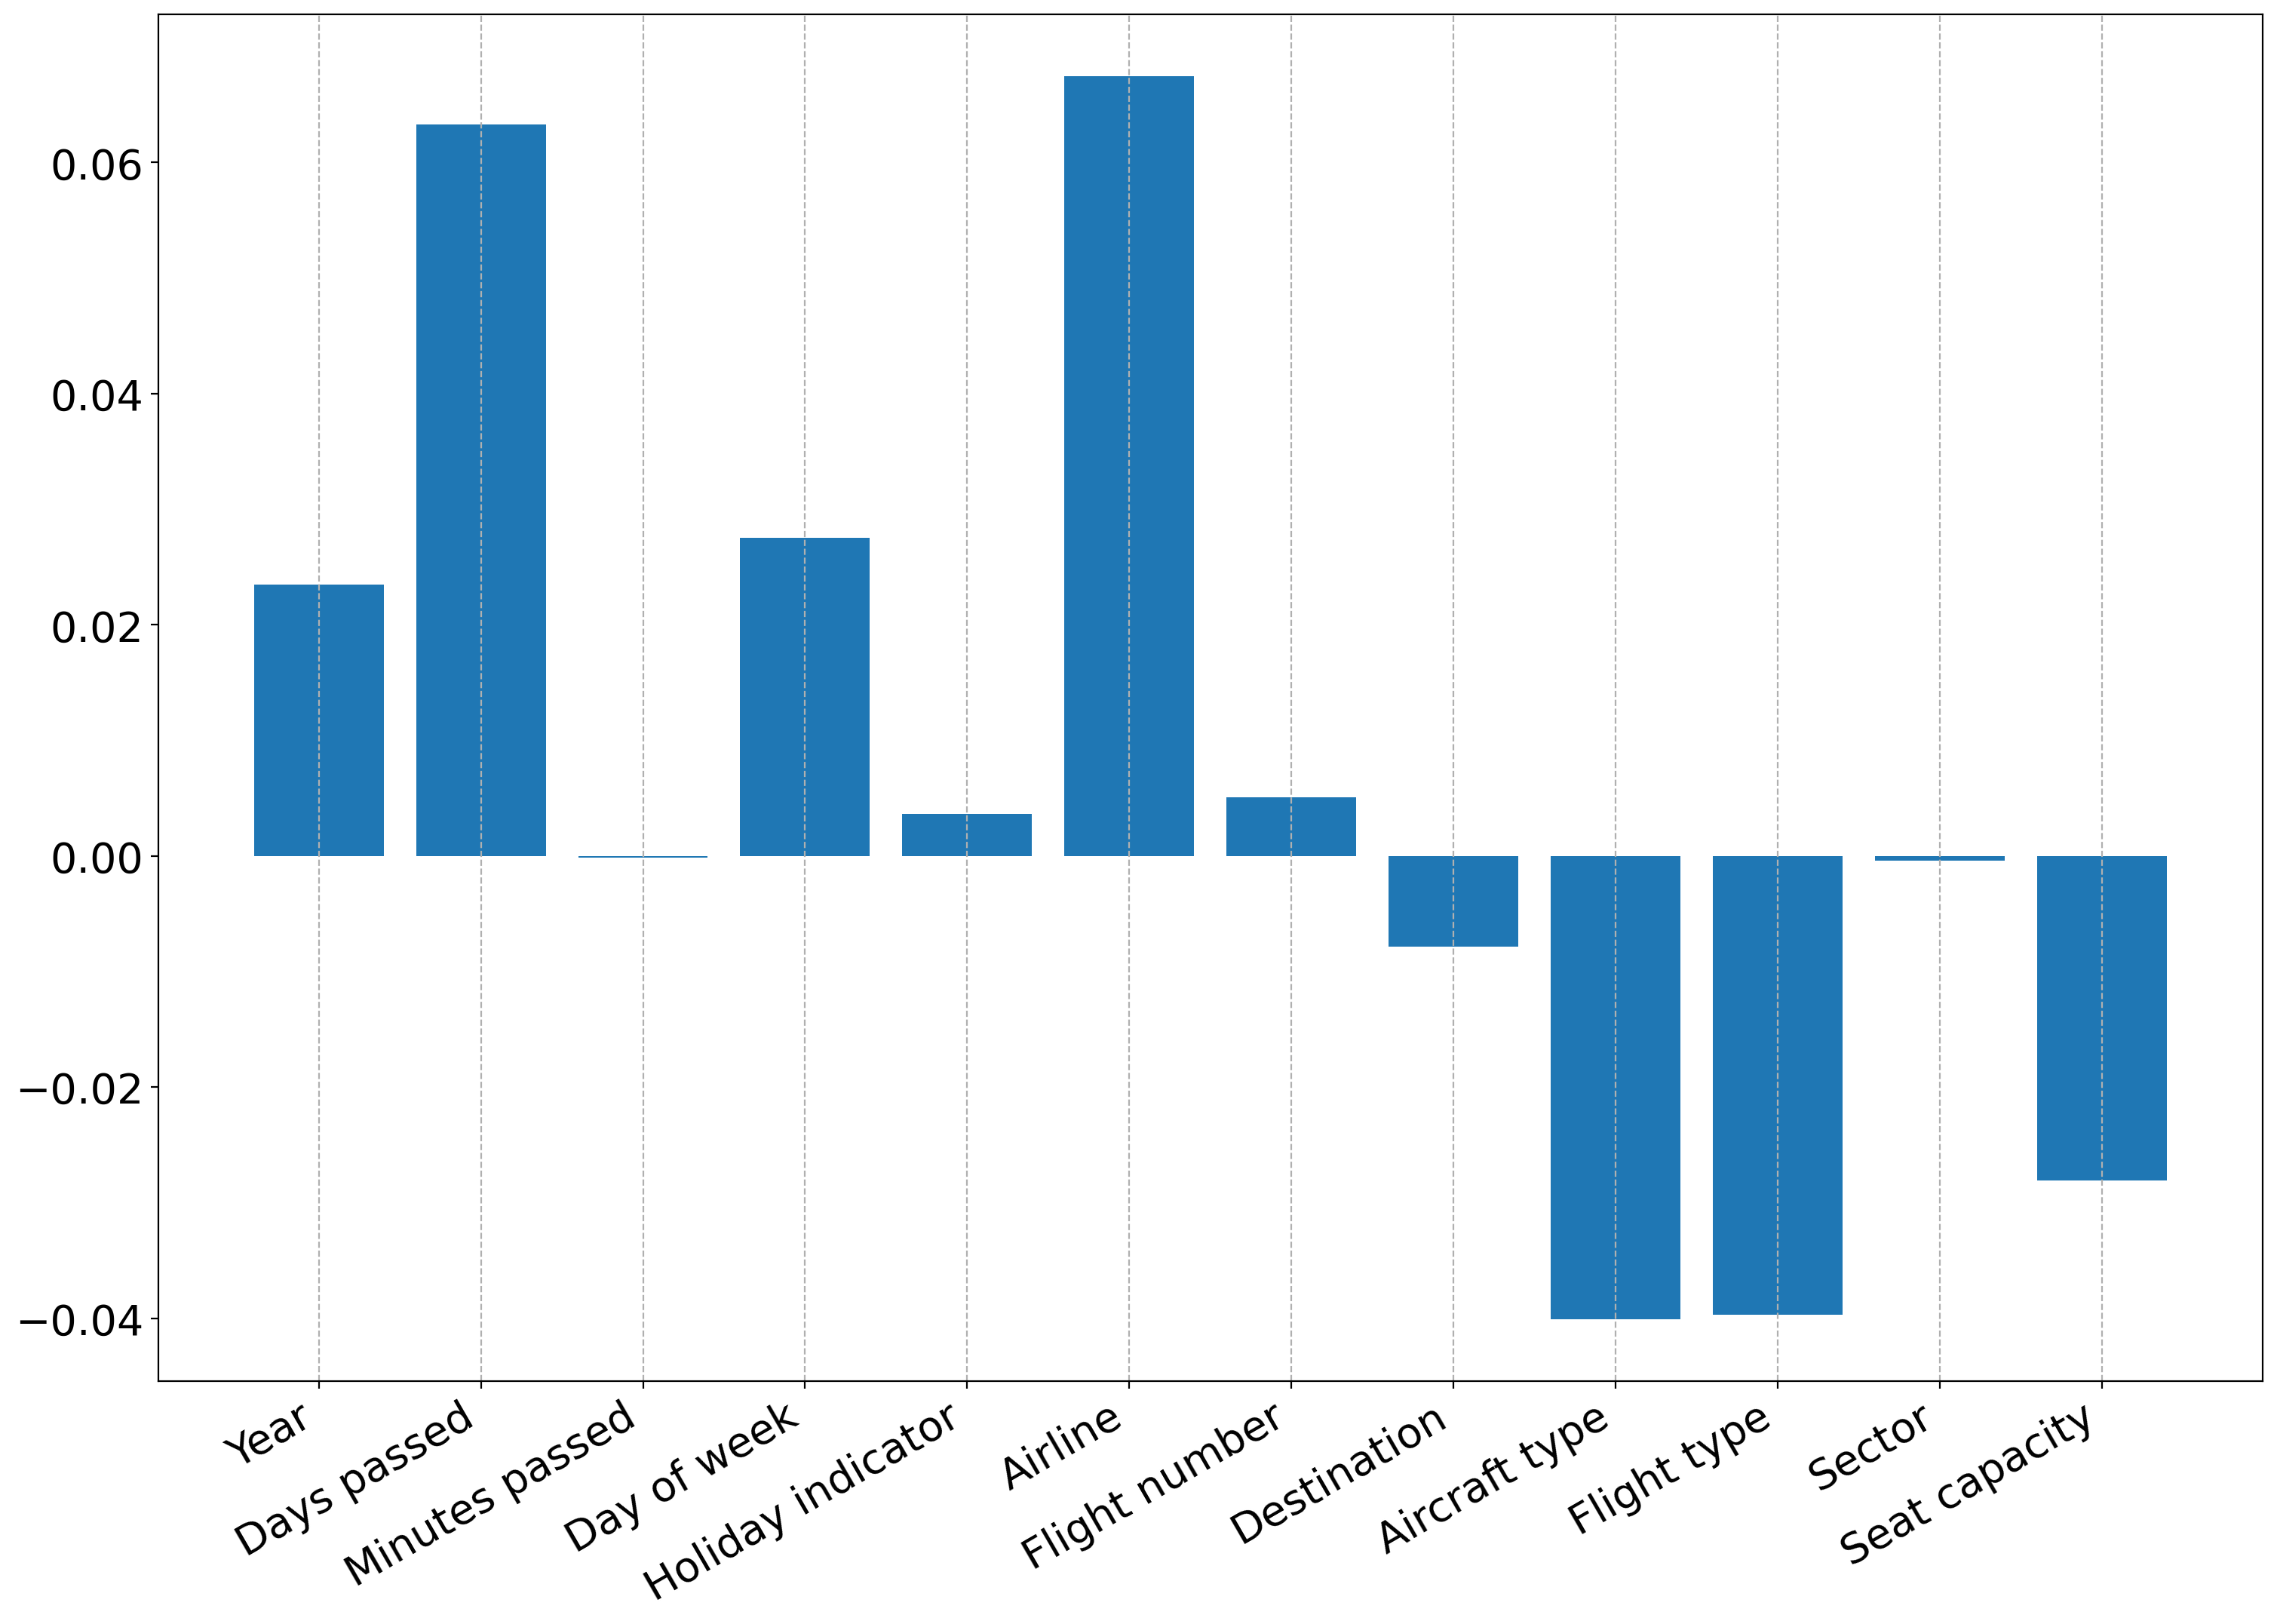

In [18]:
# Bar chart feature impotance
for i,v in enumerate(beta_ols):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
features=['Year', 'Days passed', 'Minutes passed',
         'Day of week', 'Holiday indicator', 'Airline', 'Flight number', 'Destination', 
         'Aircraft type', 'Flight type', 'Sector', 'Seat capacity']
plt.figure(figsize=(18, 12), dpi=200)
plt.bar([x for x in range(len(beta_ols))], beta_ols)
plt.xticks([x for x in range(len(beta_ols))], features, rotation = 30, fontsize = 20, ha='right')
plt.yticks(fontsize = 20)
plt.gca().xaxis.grid(True, linestyle='dashed')
plt.savefig("Figures/hist_feature_importance.png")
plt.show()

## Ridge Regression with Cross validation
$L_2$-regularization with $K=10$ fold cross-validation and one-standard-error rule to select the optimal $\lambda$.

In [19]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [20]:
def centerData(data):
    mu = np.mean(data,axis=0)
    centered_data = data - mu  
    return centered_data, mu

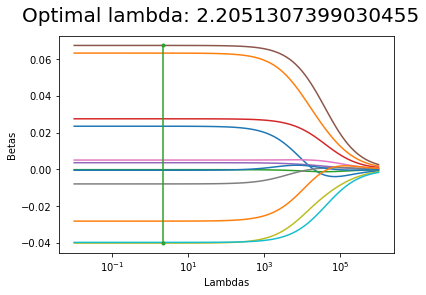

In [21]:
X_rr = raw_data[:, :-1]  # without standardization
y_rr = raw_data[:, -1]  # without standardization

X_rr_std = standardize_X(X_rr)  # apply standardization - standardized
y_rr_std = y_rr  # unstandardized

# n - the number of observations; p - the number of features
[n, p] = np.shape(X_rr)

K = 10 # the number folds
k = 100 # the number of lambdas investigated 
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-2, 6, k)
MSE = np.zeros((10, 100))

betas = np.zeros((p,k))  # p - the number of features which equals to the dimension of betas
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_rr_std, lambdas[i], p, y_rr_std)

for i in range(1, K+1):
    
    # Select the train/test data in this fold
    XTrain = X_rr[i != I, :]
    yTrain = y_rr[i != I]
    XTest = X_rr[i == I, :]
    yTest = y_rr[i == I]
    
    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)
    
    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)
    
    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data
    
    #Fit ridgeregression
    for j in range(100):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)

        
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

In [22]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.

seMSE = np.std(MSE, axis = 0) / np.sqrt(K)  # standard error
# print(meanMSE)
# print(np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE))
J = np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE)[0]  # select lambda satisfy this criteria
j = int(J[-1:])  # choose the last one - largest lambda
Lambda_CV_1StdRule = lambdas[j]
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 3.20


### Test error of Ridge Regression without and with one-standard-error rule

In [23]:
print('Test error without one-standard-error rule: {}'.format(np.mean(MSE[:, jOpt])))
print('Test error with one-standard-error rule: {}'.format(np.mean(MSE[:, j])))

Test error without one-standard-error rule: 0.06529789394162828
Test error with one-standard-error rule: 0.06552970906597733


In [24]:
# y_rr_std is actually unstandardized
beta_rr = ridgeMulti(X_rr_std, Lambda_CV_1StdRule, p, y_rr_std)
yhat_rr = np.sum(beta_rr*X_rr_std, axis=1)
MSE_rr = np.sum((y_rr_std - yhat_rr)**2)/np.size(y_rr_std)
print('Weights for Ridge Regression: \n {}'.format(beta_rr))
print('MSE for Ridge Regression: {}'.format(MSE_rr))

Weights for Ridge Regression: 
 [ 0.02350434  0.06326964 -0.00011342  0.02754416  0.00366582  0.06744018
  0.00511137 -0.00785849 -0.04005279 -0.03966144 -0.00042081 -0.0280899 ]
MSE for Ridge Regression: 0.3527253458502512


## AIC and BIC
> Notice! - this will take long time to proceed

In [171]:
# we have included 100 lambdas in CV / the noise variance s has been calculated in OLS part
D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

X_pre = X_rr_std  # standardized - features
y_pre = y_rr_std  # unstandardized - target


for j in range(100):
    beta_ridge = ridgeMulti(X_pre, lambdas[j], p, y_pre)
    
    inner = np.linalg.inv(X_pre.T @ X_pre + lambdas[j] * np.eye(p))
    outer = (X_pre @ inner) @ X_pre.T
    D[j] = np.trace(outer)  # the effective number of parameters tuned with lambda - np.trace: the sum of diagonal
    
    e = y_pre - X_pre @ beta_ridge
    err = np.sum(e ** 2) / n
    AIC[j] = err + 2 * D[j] / n * s ** 2
    BIC[j] = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

jAIC = np.argsort(AIC)[0]  # choose the index of lambda having smallest AIC
jBIC = np.argsort(BIC)[0]  # choose the index of lambda having smallest BIC

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 62.80
BIC at 335.16


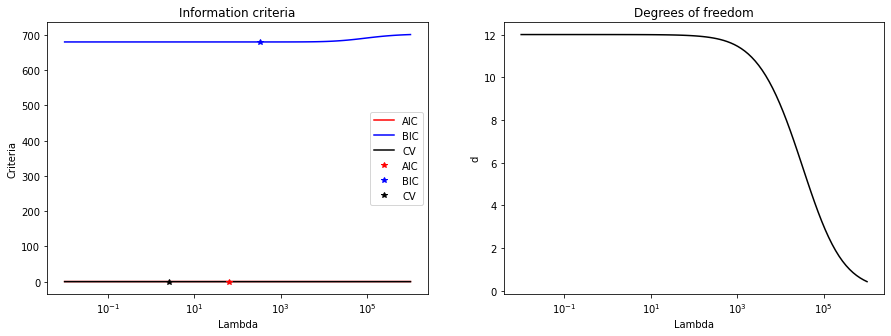

In [172]:
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#plot the degree of freedom
axs[1].semilogx(lambdas,D,'-k');
axs[1].set_title('Degrees of freedom');
axs[1].set_xlabel('Lambda');
axs[1].set_ylabel('d');

> Summary of Ridge Regression: It has no improvement comparing with OLS and even slightly worse cause the model is too simple to predict the result, which is a sign that no regularization is needed for the model.


## The Lasso
- features selection with Least Angle Regression Selection(LARS) Algorithm and Cyclical Coordinate Descent(soft thresholding)

### LARS

In [173]:
X_lars = raw_data[:, :-1]  # without standardization
y_lars = raw_data[:, -1]  # without standardization

X_lars_std = standardize_X(X_lars)  # apply standardization - standardized
y_lars_std = y_lars  # unstandardized

CV = 10  # 10-fold cross-validation

kf = KFold(n_splits=CV)
stop = n-math.ceil(n/CV)
K = range(stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

# Lars
for i, (train_index, test_index) in enumerate(kf.split(X_lars)):
    ytrain = y_lars[train_index].ravel() # ravel collapses the array, ie dim(x,1) to (x,)
    ytest = y_lars[test_index].ravel() 
    Xtrain = X_lars[train_index]
    Xtest = X_lars[test_index]

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest - mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(Xtrain.T) # Calculate training normalizer
    normalizer_test = preproc.Normalizer().fit(Xtest.T) # Calculate testing normalizer
    Xtrain = normalizer_train.transform(Xtrain.T).T # normalize training data
    Xtest = normalizer_test.transform(Xtest.T).T # normalize test data

    # compute all LARS solutions
    for j in K:
        # it is somewhat like forward step regression
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(Xtrain,ytrain)
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = Xtrain @ beta
        YhatTest = Xtest @ beta
        
        Err_tr[i-1, j] = np.mean((YhatTr-ytrain)**2) # training error
        Err_tst[i-1, j] = np.mean((YhatTest-ytest)**2) # test error
        
err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [174]:
print('The smallest test error: {}'.format(np.min(err_tst)))

The smallest test error: 0.07250120745070417


In [175]:
Betas = np.zeros((p, n))
for j in range(n):
    reg = linear_model.Lars(n_nonzero_coefs=j, normalize=True)
    reg.fit(X_lars_std,y_lars_std)
    Betas[:,i] = reg.coef_

In [176]:
for j in range(len(K)):
    Yhat = X_lars_std @ Betas[:,K[j]]

In [177]:
# this indicates that beta = 0
for i in range(len(Yhat)):
    if Yhat[i] != 0:
        print(i)
        print(Yhat[i])

In [178]:
print('MSE for Lasso with LARS: {}'.format(np.mean(((y_lars_std-Yhat)**2))))

MSE for Lasso with LARS: 0.35684719839257983


## KNN regression

In [74]:
param_grid = {'n_neighbors': np.arange(1, 12, 2),
              'weights': ['uniform', 'distance']}
knn = KNeighborsRegressor(metric='euclidean')
knn_grid= GridSearchCV(knn, param_grid, cv=KFold(n_splits=3,
                                              shuffle=True, random_state=0))
gscv.fit(X_ols, y_ols)


print("Best params", gscv.best_params_)
print("Best score", gscv.best_score_)

Best params {'n_neighbors': 7, 'weights': 'distance'}
Best score 0.5999431142170307


In [78]:
model = KNeighborsRegressor()

# GridSearchCV will replace n_neighbors by values in param_grid.
grid_search = GridSearchCV(model,
                           param_grid={"n_neighbors": range(1, 20)},
                           scoring="r2",
                           cv=10)
grid_search.fit(X_ols, y_ols)
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=9)

In [79]:
grid_search.cv_results_

{'mean_fit_time': array([0.71845319, 0.71117508, 0.7105597 , 0.71783371, 0.71482773,
        0.71252825, 0.70925519, 0.71327217, 0.71361787, 0.71375325,
        0.72369456, 0.71671946, 0.71307244, 0.71167099, 0.71049366,
        0.71572888, 0.71448848, 0.71064889, 0.71560729]),
 'std_fit_time': array([0.0158717 , 0.01226942, 0.00891303, 0.01212813, 0.0091792 ,
        0.01037964, 0.01104992, 0.00893489, 0.01224096, 0.00999793,
        0.01459331, 0.01023421, 0.01523749, 0.00987027, 0.00948374,
        0.00949662, 0.01055947, 0.01156263, 0.0095938 ]),
 'mean_score_time': array([0.24352944, 0.29062021, 0.32328053, 0.35122852, 0.36909399,
        0.38266573, 0.39763961, 0.41306796, 0.4247472 , 0.43839211,
        0.46993933, 0.46332991, 0.47023683, 0.47768464, 0.48608475,
        0.50116737, 0.50537536, 0.50934949, 0.5269747 ]),
 'std_score_time': array([0.09976565, 0.10709011, 0.11270612, 0.11942414, 0.12026196,
        0.12163258, 0.12400125, 0.1262062 , 0.12818746, 0.13098401,
        

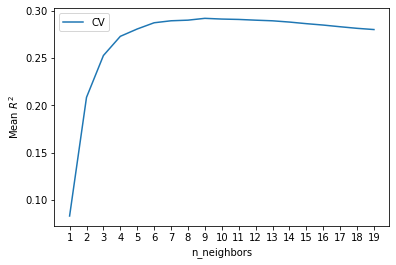

In [84]:
# --------------- Plots --------------- #
cv_score = grid_search.cv_results_['mean_test_score']


plt.figure()
plt.plot(range(1,20), cv_score, label='CV')
x = range(math.floor(min(range(1,20))), math.ceil(max(range(1,20)))+1)
plt.xticks(new_list)
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Mean $R^2$')
plt.show()